# Initialization

In [126]:
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.optimize import fsolve
import pandas as pd
import pickle

## Agent Class

In [127]:
class Agent:
  """
  id: Array index of the agent
  employed: State of the agent, whether employed or not
  strong_ties: List of ids of strong ties of this agent.
  weak_ties: List of ids of weak ties of this agent.
  """
  def __init__(self, id = 0, employed = False):
    self.id = id
    self.employed = employed
    self.strong_ties_count = 0
    self.weak_ties_count = 0
    self.strong_ties = []
    self.weak_ties = []
  def Describe(self):
    print("=============================================")
    print(f"Agent id: {self.id}")
    print(f"Employment status: {self.employed}")
    print(f"Total strong ties: {self.strong_ties_count}")
    print(f"Strong ties with Agents: {self.strong_ties}")
    print(f"Total weak ties: {self.weak_ties_count}")
    print(f"Weak ties with Agents: {self.weak_ties}")
    print("=============================================")

## Network Class

In [128]:
class Network:
  """
  Network class
  """
  def __init__(self):
    self.n_nodes = 0
    self.agents = {}
  
  def Hire(self, agent):
    """
    An Agent takes a job.
    """
    agent.employed = True
  
  def Fire(self, agent):
    """
    An Agent loses a job.
    """
    agent.employed = False

  def Recommendation(self, agent):
    """
    An Agent passes a job offer to connections.
    """
    # First choose from strong ties
    strong_unemp_connections = []
    for connection in agent.strong_ties:
      if not(self.agents[connection].employed):
        strong_unemp_connections.append(connection)
    if (len(strong_unemp_connections) > 0):
      selected_connection = np.random.choice(strong_unemp_connections)
      self.Hire(self.agents[selected_connection])
    else:
      weak_unemp_connections = []
      for connection in agent.weak_ties:
        if not(self.agents[connection].employed):
          weak_unemp_connections.append(connection)
      if (len(weak_unemp_connections) > 0):
        selected_connection = np.random.choice(weak_unemp_connections)
        self.Hire(self.agents[selected_connection])

  def MakeWeakTie(self, agent1_id, agent2_id):
    """
    Make Weak Tie between two agents by passing their IDs
    """
    agent1 = self.agents[agent1_id]
    agent2 = self.agents[agent2_id]

    # Check if weak tie already exits
    if (agent2_id in agent1.weak_ties):
      return
    # Check if strong tie already exists
    if (agent2_id in agent1.strong_ties):
      agent1.strong_ties.remove(agent2_id)
      agent2.strong_ties.remove(agent1_id)
      agent1.strong_ties_count -= 1
      agent2.strong_ties_count -= 1

    agent1.weak_ties.append(agent2_id)
    agent2.weak_ties.append(agent1_id)
    agent1.weak_ties_count += 1
    agent2.weak_ties_count += 1

  def MakeStrongTie(self, agent1_id, agent2_id):
    """
    Make Strong Tie between two agents by passing their IDs
    """
    agent1 = self.agents[agent1_id]
    agent2 = self.agents[agent2_id]

    # Check if weak tie already exits
    if (agent2_id in agent1.weak_ties):
      agent1.weak_ties.remove(agent2_id)
      agent2.weak_ties.remove(agent1_id)
      agent1.weak_ties_count -= 1
      agent2.weak_ties_count -= 1
    # Check if strong tie already exists
    if (agent2_id in agent1.strong_ties):
      return

    agent1.strong_ties.append(agent2_id)
    agent2.strong_ties.append(agent1_id)
    agent1.strong_ties_count += 1
    agent2.strong_ties_count += 1

  def BreakTie(self, agent1_id, agent2_id):
    """
    Break Existing Tie between two agents by passing their IDs
    """
    agent1 = self.agents[agent1_id]
    agent2 = self.agents[agent2_id]

    if (agent2_id in agent1.weak_ties):
      agent1.weak_ties.remove(agent2_id)
      agent2.weak_ties.remove(agent1_id)
      agent1.weak_ties_count -= 1
      agent2.weak_ties_count -= 1
    
    if (agent2_id in agent1.strong_ties):
      agent1.strong_ties.remove(agent2_id)
      agent2.strong_ties.remove(agent1_id)
      agent1.strong_ties_count -= 1
      agent2.strong_ties_count -= 1

  def GetEmpUnempLists(self):
    """
    Returns two lists, of employed & unemployed agent ids
    """
    emp_nodes_list = []
    unemp_nodes_list = []
    for node in self.agents:
      if (self.agents[node].employed):
        emp_nodes_list.append(node)
      else:
        unemp_nodes_list.append(node)
    return emp_nodes_list, unemp_nodes_list

  def GetDegrees(self):
    """
    Gets the degree of each node in network in a list
    """
    degree_list = []
    for node in self.agents:
      agent = self.agents[node]
      degree_list.append(agent.strong_ties_count + agent.weak_ties_count)
    return degree_list

  def GetBudgets(self, lamda):
    """
    Gets the budget of each agent in network in a dict
    """
    budget_list = {}
    for node in self.agents:
      agent = self.agents[node]
      budget_list[node] = agent.weak_ties_count + lamda * agent.strong_ties_count
    
    return budget_list

  def SetEmpUnempLists(self, emp_nodes_list, unemp_nodes_list):
    """
    Function to set the unemployed and employed agents of the network through passed lists
    """
    for node in emp_nodes_list:
      self.agents[node].employed = True
    for node in unemp_nodes_list:
      self.agents[node].employed = False

  def GetNodeDists(self, node_id):
    """
    Get Distance to all connected nodes from a Node.
    """
    dist_dict = {}
    dist_dict[node_id] = 0
    # Recursively find neighbours of neighbours
    idx = 0
    current_neigh = [node_id]
    while (len(current_neigh) > 0):
      idx += 1
      new_neighs = []
      # loop through each neighbour
      for neigh in current_neigh:
        # find all neighbours of each neighbour
        neigh_neighs = []
        neigh_neighs.extend(self.agents[neigh].weak_ties)
        neigh_neighs.extend(self.agents[neigh].strong_ties)

        # try to see if each of the neighbours had been included before or not
        for neigh_neigh in neigh_neighs:
          if (neigh_neigh not in dist_dict):
            new_neighs.append(neigh_neigh)
            dist_dict[neigh_neigh] = idx
      current_neigh = new_neighs

    return dist_dict
  def LongestDistFromNode(self, node_id):
    """
    Get Longest Distance From a Node.
    """
    dist_dict = self.GetNodeDists(node_id)
    idx = max(dist_dict.values())
    # Found all distances. Now report back max distance
    return idx
  
  def AverageDistFromNode(self, node_id, include_self = False):
    """
    Get Average Distance From a Node.
    Optionally calculate average distance with considering self.
    """

    dist_dict = self.GetNodeDists(node_id)
    if (not(include_self)):
      del dist_dict[node_id]
    
    if (len(dist_dict) <= 0):
      return 0
    
    return np.mean(list(dist_dict.values()))
      
  def GetLongestDists(self):
    """
    Get list of longest distances from each node.
    """
    longest_dists = []
    for agent_id in self.agents:
      longest_dists.append(self.LongestDistFromNode(agent_id))
    return longest_dists

  def GetAverageDists(self):
    """
    Get list of average distances from each node.
    """
    average_dists = []
    for agent_id in self.agents:
      average_dists.append(self.AverageDistFromNode(agent_id))
    return average_dists

  def GetFractionalDists(self):
    """
    Get ratio b/w average distance and longest distance from each node.
    """
    frac_dists = []
    for agent_id in self.agents:
      avg_dist = self.AverageDistFromNode(agent_id)
      max_dist = self.LongestDistFromNode(agent_id)
      if max_dist > 0:
        frac_dists.append(avg_dist / max_dist)
      else:
        frac_dists.append(0)
    return frac_dists

  def RandomInitialization(self, emp_prob = 0.5):
    """
    Randomly initialize the state of the network. All agents have a chance to be employed.
    """
    for agent_id in self.agents:
      if (np.random.random() < emp_prob):
        self.agents[agent_id].employed = True
      else:
        self.agents[agent_id].employed = False

  def Describe(self, show_agents = False):
    print("=============================================")
    print(f"Network with {self.n_nodes} number of nodes.")
    orphan_count = 0
    emp_count = 0
    for i in range(1, self.n_nodes):
      tie_sum = self.agents[i].strong_ties_count + self.agents[i].weak_ties_count
      if (tie_sum <= 0):
        orphan_count += 1
      if (self.agents[i].employed):
        emp_count += 1
    print(f"{orphan_count} orphaned nodes.")
    print(f"Number of employed nodes in network: {emp_count} ({(emp_count / self.n_nodes * 100):.2f}%)")
    if (self.n_nodes > 0 and show_agents):
      print(f"Details of first few nodes:")
      for i in range(1, min(self.n_nodes, 5) + 1):
        self.agents[i].Describe()
    print("=============================================")

## Generator Class

In [129]:
class Generator:
  """
  n_nodes: Total nodes to generate
  min_emp: minimum employed ratio
  max_emp: maximum employed ratio
  min_ties: minimum ties for employed node
  max_ties: ratio of maximum ties to total nodes in network for employed
  prob_strong_tie: probablility that a strong tie is formed
  max_strong_ties: by default (-1) is uncapped
  use_tie_cost_method: default true, overrides the normal tie assignment method
  lamda: cost of strong tie compared to weak tie
  min_tie_budget: minimum budget an agent has to assign ties
  max_tie_budget: ratio maximum budget an agent has to assign ties, to total nodes
  attach_bias: for scale-free network, defined as the weightage given to node with 0 ties
  final_budget: for scale-free network, defined as the final budget after upgradation
  extra_budget_tolerance: for scale-free network, defined as the threshold above final budget
  for which node is taken as hub
  rewire_prob: for small-world network, defined as the probability of rewiring per node
  """
  def __init__(self, n_nodes = 100, min_emp = 0.1, max_emp = 0.4,
               min_ties = 1, max_ties = 0.1, prob_strong_tie = 0.1,
               max_strong_ties = -1, use_tie_cost_method = True, lamda = 2.5,
               min_tie_budget = 1, max_tie_budget = 0.1, attach_bias = 0.1,
               final_budget = 18, extra_budget_tolerance = 6, rewire_prob = 0.2):
    self.n_nodes = n_nodes
    self.min_emp = int(min_emp * n_nodes)
    self.max_emp = int(max_emp * n_nodes)
    self.use_tie_cost_method = use_tie_cost_method
    self.final_budget = final_budget
    self.extra_budget_tolerance = extra_budget_tolerance
    self.attach_bias = attach_bias
    self.rewire_prob = rewire_prob

    if not(use_tie_cost_method):
      # Tie assignment quantities
      self.min_ties = min_ties
      self.max_ties = int(max_ties * n_nodes)
      self.prob_strong_tie = prob_strong_tie
      if (max_strong_ties < 0):
        self.strong_tie_cap = False
      else:
        self.strong_tie_cap = True
        self.max_strong_ties = max_strong_ties
    else:
      # using tie cost method
      self.min_tie_budget = min_tie_budget
      self.max_tie_budget = int(max_tie_budget * n_nodes)
      self.prob_strong_tie = prob_strong_tie
      self.lamda = lamda
      
    self.gen_completed = False
    self.total_connects = 0
    self.successful_connects = 0
    self.failed_connects = 0
    self.strong_connects = 0
  
  def GenerateNetwork(self, network = None, seed = 0):
    """
    The original algorithm we made to generate the network.
    Populates a network with nodes and returns it.
    This function essentially generates a random network,
    with constraints on min and max degree per node.
    """
    np.random.seed(seed)
    if network is None:
      network = Network()
    all_nodes = range(1, self.n_nodes + 1)
    n_emp = np.random.choice(range(self.min_emp, self.max_emp))

    emp_nodes_list = np.random.choice(all_nodes,size = n_emp, replace=False)
    unemp_nodes_list = [x for x in all_nodes if x not in emp_nodes_list]

    if (not(self.use_tie_cost_method)):
      # Regular method for assigning ties
      strong_ties, weak_ties = self.LegacyTieCalcMethod(emp_nodes_list, unemp_nodes_list)      
    else:
      # Tie Cost Method
      strong_ties, weak_ties = self.NewTieCostMethod(emp_nodes_list, unemp_nodes_list)

    # all ties have been assigned. Now to generate the Network model

    # Generate all the node objects
    node_objects_list = {}
    for node in all_nodes:
      if (node in emp_nodes_list):
        this_is_employed = True
      else:
        this_is_employed = False
      this_node_object = Agent(id = node, employed = this_is_employed)
      node_objects_list[node] = this_node_object
    
    # Settle all strong ties
    for tie in strong_ties:
      node_object_1 = node_objects_list[tie[0]]
      node_object_2 = node_objects_list[tie[1]]
      node_object_1.strong_ties.append(node_object_2.id)
      node_object_2.strong_ties.append(node_object_1.id)
      node_object_1.strong_ties_count += 1
      node_object_2.strong_ties_count += 1

    # Settle all weak ties
    for tie in weak_ties:
      node_object_1 = node_objects_list[tie[0]]
      node_object_2 = node_objects_list[tie[1]]
      node_object_1.weak_ties.append(node_object_2.id)
      node_object_2.weak_ties.append(node_object_1.id)
      node_object_1.weak_ties_count += 1
      node_object_2.weak_ties_count += 1

    # The generated network is now stored in the Network Class
    network.n_nodes = self.n_nodes
    network.agents = node_objects_list

    self.gen_completed = True

    return network

  def GenerateScaleFreeNetwork(self, network = None, auto_upgrade = True, seed = 0):
    """
    This function applies the Barabasi-Albert model on an existing network
    to grow it into a scale-free network. If no network model is specified,
    a random network is created.

    This function can grow an existing network in a scale-free manner
    or can also be grown later in a scale-free manner by modifying
    the n_nodes parameter.
    """
    np.random.seed(seed)
    if (network is None):
      # If no network was provided, generate an initial network using 2 data points
      network = Network()
      network.agents = {}
      network.agents[1] = Agent(id = 1)
      network.agents[2] = Agent(id = 2)
      network.MakeWeakTie(1,2)

    # With an initial network model, the network may be grown until the required size of network is
    # reached

    tie_budget = np.random.choice(range(self.min_tie_budget, self.max_tie_budget + 1))

    while (network.n_nodes <= self.n_nodes):
      
      n_nodes = network.n_nodes
      # Generate the n+1th agent
      new_agent_id = n_nodes + 1
      new_agent = Agent(id = new_agent_id)
      
      # Determine how many maximum nodes to connect
      m = min(tie_budget, n_nodes)

      # Determine weightage given to each node
      node_weights = {}
      for agent_id in network.agents:
        agent = network.agents[agent_id]
        weak_tie_count = agent.weak_ties_count
        strong_tie_count = agent.strong_ties_count
        total_budget = self.lamda * strong_tie_count + weak_tie_count
        node_weights[agent_id] = total_budget + self.attach_bias
      
      # Append agent to network
      network.agents[new_agent.id] = new_agent
      network.n_nodes += 1

      cur_budget = 0
      # Iterate over each m connection to be made
      for connect_iter in range(m):
        # Find probabilities of connecting
        node_weight_values = list(node_weights.values())
        connect_nodes = list(node_weights.keys())
        connect_prob = np.asarray(node_weight_values) / sum(node_weight_values)

        # Find a connection from existing nodes, choose one weighted to the above probability
        connect = np.random.choice(connect_nodes, p = connect_prob)
        
        network.MakeWeakTie(new_agent_id, connect)
        cur_budget += 1

        del node_weights[connect]

        if cur_budget >= m:
         break
    
    if (auto_upgrade == True):
      self.UpgradeTies(network)

    return network

  def GenerateSmallWorldNetwork(self, network = None, seed = 0):
    """
    This function applies the Watts-Strogatz model to generate a
    Small-World network of given size and required budget distribution.
    This model cannot be grown from an old network and will only replace it.
    Cannot be subsequently grown into a larger network.
    """
    np.random.seed(seed)
    # Reset the old network if it exists, or create a new one.
    network = Network()
    network.n_nodes = self.n_nodes
    all_nodes = range(1, self.n_nodes + 1)

    N = self.n_nodes
    K1 = self.min_tie_budget
    K2 = self.max_tie_budget
    beta = self.rewire_prob

    network.agents = {}
    # Generate N agents
    for agent_id in range(1, N + 1):
      network.agents[agent_id] = Agent(id = agent_id)

    # Generate K neighbours for each agent
    for agent_id in network.agents:
      idx = agent_id
      # Half the budget is allocated to neighbours on each side
      K = np.random.choice(range(K1, K2 + 1))
      K_by_2 = int((K + 1) / 2)
      # Find all candidate neighbours on left side of ring
      left_neigh = list(range(max(1, idx - K_by_2 ), idx))
      # Reverse the list, so that closest neighbours are at beginning
      left_neigh = list(reversed(left_neigh))
      # If underflow of lefthandside neighbours
      if (idx - K_by_2 < 1):
        left_neigh.extend(list(range(N - (K_by_2 - idx + 1) + 1, N + 1)))
      
      current_budget = 0
      current_neigh_index = 0
      # Join ties with these points, as long as below half-budget
      while(current_budget <= (K / 2) and current_neigh_index < (len(left_neigh))):
        
        neigh_id = left_neigh[current_neigh_index]

        # Form either strong or weak tie
        if (np.random.random() < self.prob_strong_tie):
          network.MakeStrongTie(agent_id, neigh_id)
          current_budget += self.lamda
        else:
          network.MakeWeakTie(agent_id, neigh_id)
          current_budget += 1
        
        current_neigh_index += 1
      # No need to connect to right side of ring.
      # Why because the right side of ring will eventually connect back

    # Ring formation complete. Now, randomly ties are broken in the ring,
    # and arbitrarily reassigned.

    for agent_id in network.agents:
      idx = agent_id
      # Find out how many right-hand-side neighbours agent could have made
      K2_by_2 = int((K2 + 1) / 2)
      possible_right_neigh = list(range(idx + 1, min(idx + K2_by_2 + 1, N + 1)))
      # Add overflow
      if (idx + K2 + 1 > N + 1):
        possible_right_neigh.extend(list(range(1, idx + K2_by_2 - N + 1)))

      all_agent_ties = []
      all_agent_ties.extend(network.agents[agent_id].weak_ties)
      all_agent_ties.extend(network.agents[agent_id].strong_ties)

      # Out of the possibilites, retain only those which are actually tied
      right_neigh = [tie for tie in possible_right_neigh if tie in all_agent_ties]
      # Find out all nodes not connected to this node. To avoid same-connection collisions.
      non_connects = [node for node in all_nodes if (node not in right_neigh and node != agent_id)]

      for jdx in range(len(right_neigh)):
        # Beta probability to rewire this tie
        if (np.random.random() <= beta):         
          old_connect = right_neigh[jdx]
          # Find a random node to connect to
          new_connect = np.random.choice(non_connects)

          if (old_connect in network.agents[agent_id].strong_ties):
            # Sever old tie
            network.BreakTie(agent_id, old_connect)
            network.MakeStrongTie(agent_id, new_connect)
          else:
            network.BreakTie(agent_id, old_connect)
            network.MakeWeakTie(agent_id, new_connect)
          non_connects.append(old_connect)
        
        # With 1-beta probability, the tie is left as it is
      # Rewiring complete for this particular node
    # Rewiring complete for all nodes

    # Issue employment
    n_emp = np.random.choice(range(self.min_emp, self.max_emp))
    emp_nodes_list = np.random.choice(all_nodes,size = n_emp, replace=False)

    for emp_node in emp_nodes_list:
      network.Hire(network.agents[emp_node])

    # Return Network model
    return network

  def UpgradeTies(self, network, max_budget = -1, extra_budget_tolerance = -1):
    """
    Inplace upgradation of Weak to Strong Ties.
    Function will attempt to randomly upgrade weak ties to strong ties if the budget allows it.
    A small window given for overshooting above max budget.
    Any nodes which were already above budget, will remain above budget.
    """
    
    if max_budget < 0:
      max_budget = self.final_budget
    if extra_budget_tolerance < 0:
      extra_budget_tolerance = self.extra_budget_tolerance

    # Calculate how much it costs for a single upgrade
    up_cost = self.lamda - 1
    # No point in upgrading if budget will not increase
    if up_cost <= 0:
      return

    # Find all nodes budgets
    all_budgets_list = network.GetBudgets(self.lamda)
    # Retain all nodes within budget
    budget_list = {id: budget for id,budget in all_budgets_list.items() if budget <= max_budget + extra_budget_tolerance}

    # All nodes that were already above budget, they are considered the "hub" nodes
    # Hub nodes have infinite budget by definition, but they can't add any ties themselves
    hub_list = [id for id,budget in all_budgets_list.items() if id not in budget_list]
    
    # The up_list is the subset of budget_list nodes that can actually be upgraded
    up_list = [id for id,budget in budget_list.items() if budget <= (max_budget - up_cost + extra_budget_tolerance)]

    # Not more than 1000 attempts per node
    max_iter = 1000 * len(budget_list)
    iter = 0

    # Loop through each item, until all have reached the budget
    while (iter < max_iter):
      iter += 1

      # If no more upgrades are possible, end the loop
      if (len(up_list) <= 0):
        break

      # Randomly pick something out of the upgrade list
      agent_id = np.random.choice(up_list)
      agent = network.agents[agent_id]
      # Find out if this guy actually has any neighbours who can be upgraded
      if agent.weak_ties_count <= 0:
        up_list.remove(agent_id)
        continue

      # Find out all the candidate neighbours this node has
      neigh_nodes = agent.weak_ties
      # Find out how many upgradeable neighbours this node has
      up_neighs = [id for id in neigh_nodes if id in up_list]
      # Find out how many hub neighbours this node has
      hub_neighs = [id for id in neigh_nodes if id in hub_list]
      # Rest of the nodes are at the budget limit.
      budget_neighs = [id for id in neigh_nodes if id not in up_neighs and id not in hub_neighs]

      # First preference is to upgrade alongwith another upgradeable node.
      if len(up_neighs) > 0:
        paired_node_id = np.random.choice(up_neighs)
        paired_agent = network.agents[paired_node_id]

        network.MakeStrongTie(agent_id, paired_node_id)

        new_budget = agent.weak_ties_count + self.lamda * agent.strong_ties_count
        new_pair_budget = paired_agent.weak_ties_count + self.lamda * paired_agent.strong_ties_count

        # If any of them reached their limit, then remove them from the upgrade list
        if (new_budget >= max_budget):
          up_list.remove(agent_id)
        if (new_pair_budget >= max_budget):
          up_list.remove(paired_node_id)
      
      # Second preference given to hub nodes. They are already well above budget.
      elif len(hub_neighs) > 0:
        paired_node_id = np.random.choice(hub_neighs)
        paired_agent = network.agents[paired_node_id]

        network.MakeStrongTie(agent_id, paired_node_id)

        new_budget = agent.weak_ties_count + self.lamda * agent.strong_ties_count

        # If agent reached the limit, remove it from list
        if (new_budget >= max_budget):
          up_list.remove(agent_id)
      
      # Last preference to nodes encountering budget limit. They will overshoot and become hubs.
      else:
        paired_node_id = np.random.choice(budget_neighs)
        paired_agent = network.agents[paired_node_id]

        network.MakeStrongTie(agent_id, paired_node_id)

        new_budget = agent.weak_ties_count + self.lamda * agent.strong_ties_count
        new_pair_budget = paired_agent.weak_ties_count + self.lamda * paired_agent.strong_ties_count

        # If agent reached the limit, remove it from list
        if (new_budget >= max_budget):
          up_list.remove(agent_id)
        # If the pair agent reach the limit, promote it to a hub
        if (new_pair_budget >= max_budget + extra_budget_tolerance):
          if (paired_node_id in up_list):
            up_list.remove(paired_node_id)
          hub_list.append(paired_node_id)
    
    # All agents are on or above budget. Now we can return from the algorithm
    # New data is stored in network, therefore return value need not be used
    return(network)

  def LegacyTieCalcMethod(self, emp_nodes_list, unemp_nodes_list):
    """
    The legacy method we used to assign ties as per Random Network model.
    This method isn't preferred as it doesn't consider budgets.
    """
    all_nodes = range(1, self.n_nodes + 1)
    edges_list = []
    node_tie_dict = {k:0 for k in all_nodes}

    edge_strong = []
    edge_weak = []

    # Make connections for each node
    for node in all_nodes:
      num_ties = np.random.choice(range(self.min_ties, self.max_ties + 1))
      connects = np.random.choice(all_nodes,size = num_ties,replace=False)
      for connect in connects:
        self.total_connects += 1
        if (connect == node or (connect, node) in edges_list):
          self.failed_connects += 1
          continue
        if node_tie_dict[connect] < self.max_ties:
          node_tie_dict[node] += 1
          node_tie_dict[connect] += 1
          edges_list.append((node,connect))
          self.successful_connects += 1
        else:
          self.failed_connects += 1

    strong_ties = []
    weak_ties = []
    strong_ties_counts = {k: 0 for k in all_nodes}

    # Assign strength to each tie
    for edge in edges_list:
      node1 = edge[0]
      node2 = edge[1]
      strong_tie_count = max(strong_ties_counts[node1], strong_ties_counts[node2])
      if np.random.random() < self.prob_strong_tie and not(self.strong_tie_cap and strong_tie_count >= self.max_strong_ties):
        strong_ties.append(edge)
        self.strong_connects += 1
      else:
        weak_ties.append(edge)
    return strong_ties, weak_ties

  def NewTieCostMethod(self, emp_nodes_list, unemp_nodes_list):

    """
    New method to assign ties in GenerateNetwork function. More efficient than OldTieCostMethod.
    """

    all_nodes = range(1, self.n_nodes + 1)
    edges_list = []
    strong_ties = []
    weak_ties = []
    cost_dict = {k: 0 for k in all_nodes}

    # Iterate over each node
    for node in all_nodes:
      tie_budget = np.random.choice(range(self.min_tie_budget, self.max_tie_budget + 1))
      cur_budget = cost_dict[node]
      av_budget = tie_budget - cur_budget
      if av_budget < 1:
        continue 
      max_st = int(av_budget / self.lamda)

      # Decide how many strong ties to make
      x = np.random.choice(range(0, max_st + 1))
      y = max(int(tie_budget - self.lamda*x),0)

      available_connects = [k for (k, cost) in cost_dict.items() if (cost <= self.max_tie_budget - self.lamda) and k != node]
      available_connects = [k for k in available_connects if (k,node) not in edges_list]
      num_connects = len(available_connects)
      if num_connects < 1:
        continue
      # Choose x+y ties
      chosen_connects = np.random.choice(available_connects, size= min(x+y,num_connects), replace = False)
      np.random.shuffle(chosen_connects)
      # Amongst the above connections, choose x strong ties
      chosen_strong_ties = []
      chosen_weak_ties = []
      if x > 0:
        chosen_strong_ties = chosen_connects[0:x]
      if x < len(chosen_connects):
        chosen_weak_ties = chosen_connects[x:len(chosen_connects)]

      # Assign ties
      for st in chosen_strong_ties:
        new_edge = (node,st)
        strong_ties.append(new_edge)
        cost_dict[node] += self.lamda
        cost_dict[st] += self.lamda
        self.strong_connects += 1
        self.successful_connects += 1
        edges_list.append(new_edge) 

      for wt in chosen_weak_ties:
        new_edge = (node,wt)
        weak_ties.append(new_edge)
        cost_dict[node] += 1
        cost_dict[wt] += 1
        self.successful_connects += 1
        edges_list.append(new_edge) 


    return strong_ties, weak_ties

  def OldTieCostMethod(self, emp_nodes_list, unemp_nodes_list):

    """
    Old Method to compute ties using budget costs,
    however results in some failures due to inefficient assignment.
    """

    all_nodes = range(1, self.n_nodes + 1)
    edges_list = []
    strong_ties = []
    weak_ties = []
    cost_dict = {k: 0 for k in all_nodes}

    for node in all_nodes:
      tie_budget = np.random.choice(range(self.min_tie_budget, self.max_tie_budget + 1))
      # Keep assigning ties as long as below tie budget
      iter_limit = self.n_nodes
      iter_count = 0
      while cost_dict[node] < tie_budget and iter_count <= iter_limit:
        iter_count += 1
        self.total_connects += 1
        # Find a node to pair with
        connect = np.random.choice(all_nodes)

        # Check if already connected, or is the same node
        if ((connect,node) in edges_list or connect == node):
          self.failed_connects += 1
          continue
        
        # Check if connection can afford a new tie
        if (cost_dict[connect] >= self.max_tie_budget):
          self.failed_connects += 1
          continue

        # New connection is made
        new_edge = (node,connect)

        # Decide to create either a strong or weak tie
        if np.random.random() < self.prob_strong_tie:

          # Check for strong tie budget
          if (cost_dict[connect] + self.lamda > self.max_tie_budget or cost_dict[node] + self.lamda > self.max_tie_budget):
            self.failed_connects += 1
            continue

          # Create a strong tie
          strong_ties.append(new_edge)
          cost_dict[node] += self.lamda
          cost_dict[connect] += self.lamda
          self.strong_connects += 1
        else:

          # Check for weak tie budget
          if (cost_dict[connect] + 1 > self.max_tie_budget or cost_dict[node] + 1 > self.max_tie_budget):
            self.failed_connects += 1
            continue
          
          # Create a weak tie
          weak_ties.append(new_edge)
          cost_dict[node] += 1
          cost_dict[connect] += 1
        
        edges_list.append(new_edge)
        self.successful_connects += 1    
    return strong_ties, weak_ties

  def Reset(self):
    self.gen_completed = False
    self.total_connects = 0
    self.successful_connects = 0
    self.failed_connects = 0
    self.strong_connects = 0

  def Describe(self):
    print("=============================================")
    print(f"Generator class of node capacity {self.n_nodes}.")
    print(f"Min/Max Employment counts: {self.min_emp}/{self.max_emp}")
    if (not(self.use_tie_cost_method)):
      print(f"Min/Max Employment ties: {self.min_emp_ties}/{self.max_emp_ties}")
      print(f"Min/Max Unemployment ties: {self.min_unemp_ties}/{self.max_unemp_ties}")
      print(f"Strong tie probability: {self.prob_strong_tie}")
      if (self.strong_tie_cap):
        print(f"Max strong ties per node: {self.max_strong_ties}")
    else:
      print(f"Min/Max Tie Budget: {self.min_tie_budget}/{self.max_tie_budget}")
      print(f"Strong tie probability: {self.prob_strong_tie}")
      print(f"Relative cost of strong tie: {self.lamda}")

    if (self.gen_completed):
      print(f"Generation completed. Resulted in a network of {self.n_nodes} nodes.")
      print(f"Total connections generated: {self.total_connects}")
      print(f"Successful ties made: {self.successful_connects} ({(self.successful_connects / self.total_connects * 100):.2f}%)")
      print(f"Failed tie attempts: {self.failed_connects} ({(self.failed_connects / self.total_connects * 100):.2f}%)")
      print(f"Strong ties made: {self.strong_connects} ({(self.strong_connects / self.total_connects * 100):.2f}%)")
    print("=============================================")

## Simulator Class

In [130]:
class Simulator:
  """
  hire_prob: Probability of hearing about a job in every time step
  fire_prob: Probability of being fired from existing job in every time step
  """
  def __init__(self, network, hire_prob = 0.4, fire_prob = 0.4, sim_steps = 1000):
    self.network = network
    self.alpha = hire_prob
    self.beta = fire_prob
    self.max_steps = 1000
    self.steps = 0
    self.sim_complete = False
  def SimOneTimeStep(self):
    """
    A single Simulation Step. This function may be called in a loop to perform a simulation.
    """
    # HIRE EVENT
    # Hear about job with alpha probability
    for agent_id in self.network.agents:
      agent = self.network.agents[agent_id]
      if np.random.random() < self.alpha:
        # Heard about job
        if agent.employed:
          self.network.Recommendation(agent)
        else:
          self.network.Hire(agent)
    
    # FIRE EVENT
    # Fire with beta probability if employed
    for agent_id in self.network.agents:
      agent = self.network.agents[agent_id]
      if agent.employed:
         if np.random.random() < self.beta:
           self.network.Fire(agent)
    

    self.steps += 1

  def PerformSimulation(self, sim_steps = 0):
    """
    Shortcut Function to perform Simulation on linked Network from start to end with given settings.
    For more control over the simulation, call SimOneTimeStep in a loop instead.
    """
    if sim_steps <= 0:
      max_steps = self.max_steps + self.steps
    else:
      max_steps = sim_steps + self.steps

    self.sim_complete = False

    while not(self.sim_complete):
      self.SimOneTimeStep()
      if (self.steps >= max_steps):
        self.sim_complete = True

  def Describe(self):
    print("=============================================")
    print(f"Simulator class linked to a Network of {self.network.n_nodes} nodes.")
    print(f"Hire / Fire Probabilities: {self.alpha * 100:.2f}% / {self.beta * 100:.2f}%")
    print(f"Current / Maximum Simulation steps: {self.steps} / {self.max_steps}")
    if(self.sim_complete):
      print(f"Simulation completed.")
    print("=============================================")

## Plotter Class

In [131]:
class Plotter:
  """
  Plotter class contains helpful plotting functions.
  """
  def __init__(self, network, simulator, generator = None, node_size = 100, weak_tie_opacity = 0.5,
               strong_tie_opacity = 1, node_size_scaling = -1, figsize = (10,10), tie_width = 2,
               strong_tie_width_multiplier = 5):
    self.network = network
    self.simulator = simulator
    self.generator = generator

    self.node_size = node_size
    self.weak_tie_opacity = weak_tie_opacity
    self.strong_tie_opacity = strong_tie_opacity

    # Node size scaling parameter, if defined, describes how large the highest-degree node will be
    # in comparison to the smallest-degree node
    if (node_size_scaling > 0):
      self.use_node_size_scaling = True
      self.node_size_scaling = node_size_scaling
    else:
      self.use_node_size_scaling = False
    self.figsize = figsize
    self.tie_width = tie_width
    self.strong_tie_width_multiplier = strong_tie_width_multiplier
    self.colour_scheme = ['#0d664a','#1fbf3c']

  def GetEdgesLists(self):
    """
    Function for internal use. Returns the edges of the network in a tuple-list format.
    """
    edges_list = []
    strong_ties_list = []
    weak_ties_list = []

    for node in self.network.agents:
      strong_ties = self.network.agents[node].strong_ties
      weak_ties = self.network.agents[node].weak_ties
      for connect in strong_ties:
        if (connect,node) not in edges_list:
          edges_list.append((node,connect))
          strong_ties_list.append((node,connect))
      for connect in weak_ties:
        if (connect,node) not in edges_list:
          edges_list.append((node,connect))
          weak_ties_list.append((node,connect))
          
    return edges_list, strong_ties_list, weak_ties_list

  def PlotNetwork(self, title = "Network Plot", saveto = None):
    """
    Function to plot the network in its current state.
    """

    G1 = nx.Graph()
    nodes_list = self.network.agents.keys()

    # Add nodes
    G1.add_nodes_from(nodes_list)

    # Reverse-engineer the edges lists
    edges_list, strong_ties_list, weak_ties_list = self.GetEdgesLists()

    G1.add_edges_from(edges_list)

    # Find employment data
    emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()

    plt.figure(figsize = self.figsize)
    plt.title(title, fontsize = 24)

    pos = nx.nx_pydot.graphviz_layout(G1)
    
    # draw nodes
    # Either draw them of uniform size
    if (not(self.use_node_size_scaling)):
      nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=unemp_nodes_list, node_color=self.colour_scheme[0])
      nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=emp_nodes_list, node_color=self.colour_scheme[1])
    # Or draw them with size scaling wrt degree of network
    else:
      # Obtain the degree distribution in dict form
      deg_dict = {id: (node.weak_ties_count + node.strong_ties_count) for id,node in self.network.agents.items()}
      max_deg = max(deg_dict.values())
      min_deg = min(deg_dict.values())
      # If there is no variation in size, draw nodes as-is
      if max_deg <= min_deg:
        nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=unemp_nodes_list, node_color=self.colour_scheme[0])
        nx.draw_networkx_nodes(G1, pos, node_size=self.node_size, nodelist=emp_nodes_list, node_color=self.colour_scheme[1])
        # Draw each node one-by-one, respecting its relative degree
      else:
        for node in self.network.agents:
          cur_node_deg = deg_dict[node]
          cur_node_size = self.node_size * (1 + (cur_node_deg - min_deg) / (max_deg - min_deg) * self.node_size_scaling)
          if self.network.agents[node].employed:
            cur_node_colour = self.colour_scheme[1]
          else:
            cur_node_colour = self.colour_scheme[0]
          nx.draw_networkx_nodes(G1, pos, node_size=cur_node_size, nodelist=[node], node_color=cur_node_colour)
                                            
    # draw edges
    nx.draw_networkx_edges(G1, pos, edgelist=strong_ties_list, alpha=self.strong_tie_opacity, width=(self.strong_tie_width_multiplier * self.tie_width))
    nx.draw_networkx_edges(G1, pos, edgelist=weak_ties_list, alpha=self.weak_tie_opacity, width=self.tie_width)
    if (saveto is not None):
      plt.savefig(saveto)
    plt.show()
      
  def PlotTieDist(self, title = "Tie Frequency Distribution", saveto = None):
    """
    Function to plot Degree Distribution of Network.
    """
    nodes_list = self.network.agents.keys()
    tie_counts = []
    # Get the tie statistics
    for node in nodes_list:
      tie_count = self.network.agents[node].strong_ties_count + self.network.agents[node].weak_ties_count
      tie_counts.append(tie_count)
    
    binwidth = 1

    plt.figure(figsize = self.figsize)
    plt.title(title, fontsize = 24)
    plt.hist(tie_counts, bins=range(min(tie_counts), max(tie_counts) + binwidth, binwidth))
    plt.xlabel("Tie Count", fontsize = 20)
    plt.ylabel("Frequency", fontsize = 20)
    if (saveto is not None):
      plt.savefig(saveto)
    plt.show()

  def PlotBudgetDist(self, lamda = -1, title = "Budget Frequency Distribution"):
    """
    Function to plot Budget Distribution of network.
    """
    if self.generator is None:
      if lamda < 1:
        print("PlotBudgetDist failed. Require value of lamda > 1")
        return
    else:
      lamda = self.generator.lamda

    budget_list = self.network.GetBudgets(lamda)
    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(budget_list.values())
    plt.show()

  def PlotStrongTieDist(self, title = "Strong Tie Frequency Distribution", fractional_dist = False,
                        only_employed = False, only_unemployed = False):
    """
    Function to plot Strong Tie Distrubutions, either in numerical or fractional quantities.
    """
    nodes_list = self.network.agents.keys()

    if only_employed:
      emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()
      nodes_list = emp_nodes_list
    elif only_unemployed:
      emp_nodes_list, unemp_nodes_list = self.network.GetEmpUnempLists()
      nodes_list = unemp_nodes_list

    strong_tie_counts = []
    # Get the tie statistics
    for node in nodes_list:
      strong_tie_count = self.network.agents[node].strong_ties_count
      weak_tie_count = self.network.agents[node].weak_ties_count
      tie_count = strong_tie_count + weak_tie_count
      if (fractional_dist and tie_count > 0):
        strong_tie_counts.append(strong_tie_count / tie_count)
      else:
        strong_tie_counts.append(strong_tie_count)
    
    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(strong_tie_counts)
    plt.show()

  def PlotLongestDistsDist(self, title = "Longest Distance Distribution"):
    """
    Function to plot distribution of longest path lengths.
    """
    longest_dists = self.network.GetLongestDists()

    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(longest_dists)
    plt.show()

  def PlotAverageDistsDist(self, title = "Average Distance Distribution"):
    """
    Function to plot average distribution of path lengths
    """
    longest_dists = self.network.GetAverageDists()

    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(longest_dists)
    plt.show()

  def PlotFractionalDistsDist(self, title = "Ratio of l to lmax"):
    """
    Function to plot ratio of average to longest path length distribution.
    """
    frac_dists = self.network.GetFractionalDists()

    plt.figure(figsize = self.figsize)
    plt.title(title)
    plt.hist(frac_dists)
    plt.show()

  def GetEmpStrongTieCorr(self, sim_steps = 1000, n_realisations = 1, n_networks = 1, pre_steps = 0, 
                          title = "Employment Chance vs Strong Tie Fraction", disable_plot = False,
                          only_consider_below_budget = -1, only_consider_above_budget = -1,
                          lamda = -1, network_type = "None", return_data = False, 
                          auto_expand = True, auto_N = 1000):
    """
    A complex function that takes a network model, simulates it for many time-steps, and plots the 
    distribution of employment chance against strong tie fraction. It also returns the correlation 
    of the observed plot. Optionally, it also may return the distributed data, either in raw format 
    or after interpolation and smoothing.
    """
    nodes_list = self.network.agents.keys()
    # If we are culling the hub nodes
    if only_consider_below_budget >= 1 or only_consider_above_budget >= 1:
      # If the lamda value wasn't specified
      if self.generator is None:
        if lamda < 1:
          # We don't have the lamda value to compare budgets. Error occured
          raise ValueError("Add generator class to plotter, or pass lamda value to function")
      else:
        lamda = self.generator.lamda

    # Over Multiple Networks Generated, Averaged Over Multiple Realisations
    all_strong_tie_fracs = []
    all_emp_timestep_fracs = []

    # Create n_networks such networks, and run them n_realizations number of times
    for network_idx in range(n_networks):
      
      # For the second iteration onwards, redefine the network.
      # This is to ensure that for one iteration alone, network is untouched.
      if (network_idx > 0):
        if (self.generator is not None):
          if (network_type == "Random"):
            self.network = self.generator.GenerateNetwork(seed = network_idx)
          if (network_type == "ScaleFree"):
            self.network = self.generator.GenerateScaleFreeNetwork(seed = network_idx)
          if (network_type == "SmallWorld"):
            self.network = self.generator.GenerateSmallWorldNetwork(seed = network_idx)
        self.simulator.network = self.network

      emp_list, unemp_list = self.network.GetEmpUnempLists()
      avg_emp_timestep_fracs = np.zeros(len(nodes_list))

      for realisation in range(n_realisations):
        # Reset the state of the network. If the network becomes complex,
        # we should add deepcopy instead

        self.network.SetEmpUnempLists(emp_list, unemp_list)
        
        agent_data_dict = {k: [0,0] for k in nodes_list}
        steps = 0
        # Run the sim, and count the employment occurences
        while steps < sim_steps:
          steps += 1
          self.simulator.SimOneTimeStep()
          for node in nodes_list:
            if self.network.agents[node].employed:
              agent_data_dict[node][0] += 1
        
        # Counted occurences. Now Find strong tie ratios for each agent

        for node in nodes_list:
          agent = self.network.agents[node]
          # If we are culling the hub nodes
          if only_consider_below_budget >= 1:
            budget = agent.strong_ties_count * lamda + agent.weak_ties_count
            # if above specified budget
            if budget > only_consider_below_budget:
              # The strong try frac for the hub nodes are tagged, so they later may be removed
              agent_data_dict[node][1] = -1
              continue
          
          # If we are culling the low-budget nodes
          if only_consider_above_budget >=1:
            budget = agent.strong_ties_count * lamda + agent.weak_ties_count
            # if above specified budget
            if budget < only_consider_above_budget:
              # The strong try frac for the hub nodes are tagged, so they later may be removed
              agent_data_dict[node][1] = -1
              continue

          strong_tie_count = agent.strong_ties_count
          weak_tie_count = agent.weak_ties_count
          tie_count = strong_tie_count + weak_tie_count
          if (tie_count <= 0):
            agent_data_dict[node][1] = 0
          else:
            agent_data_dict[node][1] = (strong_tie_count / tie_count)
          
        emp_timestep_counts, strong_tie_fracs = zip(*agent_data_dict.values())
        emp_timestep_fracs = np.asarray([count / sim_steps for count in emp_timestep_counts])
        avg_emp_timestep_fracs += emp_timestep_fracs / n_realisations
      
      # Remove tagged nodes
      if only_consider_below_budget >= 1 or only_consider_above_budget >= 1:
        paired_node_data = zip(strong_tie_fracs , avg_emp_timestep_fracs)
        paired_node_data = [[stf,avtf] for stf, avtf in paired_node_data if stf >= 0]
        strong_tie_fracs , avg_emp_timestep_fracs = zip(*paired_node_data)

      # Add the tally to the overall plot
      all_strong_tie_fracs.extend(strong_tie_fracs)
      all_emp_timestep_fracs.extend(avg_emp_timestep_fracs)
    if not(disable_plot):
      plt.figure(figsize = self.figsize)
      if (self.generator is not None):
        title_addendum = f" [a/b={self.simulator.alpha}/{self.simulator.beta}, lamda = {self.generator.lamda}]"
      else:
        title_addendum = f" [a/b={self.simulator.alpha}/{self.simulator.beta}]"
      plt.title(title + title_addendum)
      plt.scatter(all_strong_tie_fracs , all_emp_timestep_fracs)
      plt.xlabel('Fraction of Strong Ties')
      plt.ylabel(f'Average Employment % over {sim_steps} steps')
      plt.show()
    corr = np.corrcoef(all_strong_tie_fracs, all_emp_timestep_fracs)[0][1]
    if (not(return_data)):
      return corr
    else:
      if (auto_expand):
        data = (all_strong_tie_fracs, all_emp_timestep_fracs)
        data_strip = plotter.ConvertToDataStrip(data, tol = 0.05)
        interp_data_strip = plotter.ExpandDataStrip(data_strip, N_expanded = auto_N)
        return corr, interp_data_strip
      else:
        return corr, (all_strong_tie_fracs, all_emp_timestep_fracs)
  
  def ExpandDataStrip(self, data_strip, N_expanded):
    """
    Interpolates a Data Strip for heatmap purposes.
    """
    # Assumed that all r values are unique and sorted
    (r, p_new) = data_strip
    
    rmin = min(r)
    rmax = max(r)

    N = N_expanded  
    step_length = 1 / (N - 1)

    r_interp = np.zeros(N)
    p_interp = np.zeros(N)

    r_idx = 0
    # Interpolate for each value inbetween r
    for idx in range(N):
      r_interp[idx] = r_idx
      if (r_idx < rmin or r_idx >= rmax):
        r_idx = r_idx + step_length
        continue
      # Find the neighbouring two points
      for jdx in range(len(r)):
        if r[jdx] >= r_idx:
          r_more = r[jdx]
          r_less = r[jdx - 1]
          p_more = p_new[jdx]
          p_less = p_new[jdx - 1]
          break
      
      # Found neighbouring two points. Now set p_new value
      p_idx = p_less + (r_idx - r_less) / (r_more - r_less) * (p_more - p_less)
      p_interp[idx] = p_idx
      r_idx = r_idx + step_length
    
    # Return interpolated values
    return r_interp, p_interp
      
  def ColumnWiseSmoothing(self, array, tol = 1e-4):
    """
    Performs column wise smoothing to impute even more values
    """
    A = array
    r = A.shape[0]
    c = A.shape[1]

    # Iterate through each column
    for jdx in range(c):
      col_vals = A[:,jdx]
      # find the indices where values actually exist
      nonzero_ind = np.asarray(sorted(np.nonzero(col_vals > tol))).flatten()

      if len(nonzero_ind) <= 1:
        continue

      min_ind = np.min(nonzero_ind)
      max_ind = np.max(nonzero_ind)
      
      # Iterate through each element in this column
      for idx in range(r):
        cur_val = A[idx, jdx]
        if idx < min_ind or idx > max_ind:
          continue
        if idx in nonzero_ind:
          continue
        # Find the neighbouring indices
        for kdx in range(len(nonzero_ind)):
          if nonzero_ind[kdx] >= idx:
            more_idx = nonzero_ind[kdx]
            less_idx = nonzero_ind[kdx - 1]
            more_val = col_vals[more_idx]
            less_val = col_vals[less_idx]
            break
        # Found neighbouring indices. Now interp between them
        cur_val = less_val + (idx - less_idx) / (more_idx - less_idx) * (more_val - less_val)
        A[idx, jdx] = cur_val
        
    return A

  def ConvertToDataStrip(self, data, tol = 1e-4):
    """
    Converts distribution of r vs p_new data into a linear strip by averaging over r.
    """
    (r, p_new) = data
    
    r_vals = []
    p_vals = []

    r_vals.append(r[0])
    p_vals.append([])
    p_vals[0].append(p_new[0])

    # Loop over each element, add to an existing list item, if r corresponds to that item
    for idx in range(1, len(r)):
      r_idx = r[idx]
      p_idx = p_new[idx]

      dist_from_r_vals = np.abs(r_idx - np.asarray(r_vals))
      if np.min(dist_from_r_vals) < tol:
        # Add to existing array element
        exist_idx = np.argmin(dist_from_r_vals)
        p_vals[exist_idx].append(p_idx)
      else:
        # Add a new array element
        new_idx = len(r_vals)
        r_vals.append(r_idx)
        p_vals.append([])
        p_vals[new_idx].append(p_idx)
    
    # All elements have been introduced into their respective bins. Now we can take mean
    mean_p_vals = []
    for p_val_list in p_vals:
      mean_p_vals.append(np.mean(p_val_list))

    sorted_data_strip = sorted(zip(r_vals,mean_p_vals), key=lambda pair: pair[0])
    r_sorted, p_sorted = zip(*sorted_data_strip)
    return (r_sorted, p_sorted)
  
  def Describe(self):
    print("=============================================")
    print(f"Plotter for Network of {self.network.n_nodes} Nodes.")
    print("=============================================")

# Example Script

Section used for testing code

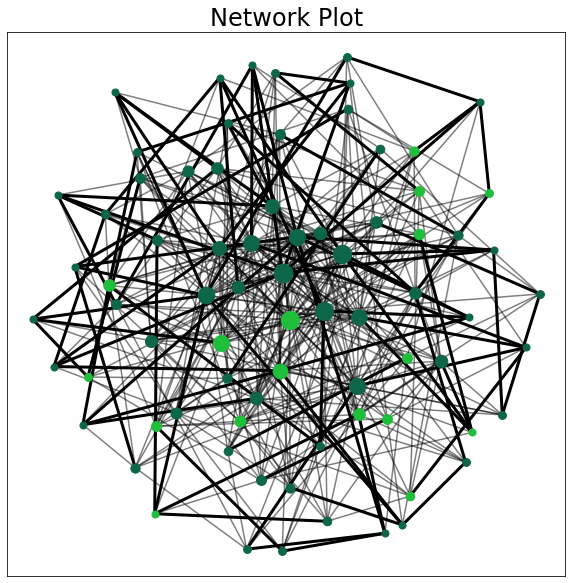

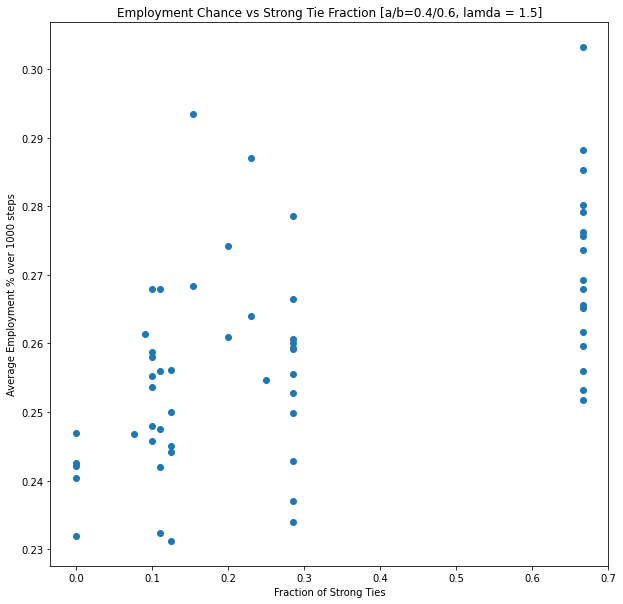

Observed correlation: 0.5415978292167006


In [146]:
# Define Network Parameters
lamda = 1.5
n_nodes = 75
max_tie_budget = 6
min_tie_budget = 2

# Some parameters are unique to the topology of the network. See Generator class for details.
final_budget = 8
extra_budget_tolerance = 4


# Define the generator object
generator = Generator(n_nodes= n_nodes, min_tie_budget= min_tie_budget,
                      max_tie_budget = max_tie_budget / n_nodes, lamda = lamda, attach_bias = 0.001,
                      final_budget = final_budget, extra_budget_tolerance= extra_budget_tolerance)

# Generate a network object from the generator
network = generator.GenerateScaleFreeNetwork(seed = 0)

# Define the simulator object
simulator = Simulator(network, hire_prob = 0.4, fire_prob= 0.6)
# Define the plotter object
plotter = Plotter(network, simulator, generator, tie_width= 1.5, strong_tie_width_multiplier= 2,
                  node_size = 50, node_size_scaling = 6)

# Quick method to perform the simulation
simulator.PerformSimulation(sim_steps= 1000)

# Alternatively, for more control over the simulation, use:

# sim_steps = 1000
# for step in range(sim_steps):
#   simulator.SimOneTimeStep()

# Examples of plot functions

plotter.PlotNetwork()
# plotter.PlotTieDist()
# plotter.PlotBudgetDist()
# plotter.PlotStrongTieDist()

# Used for the correlation plots and subsequent analysis

corr, interp_data_strip = plotter.GetEmpStrongTieCorr(
    n_realisations= 5, network_type= 'ScaleFree', only_consider_below_budget= 15,
    return_data = True)

print(f"Observed correlation: {corr}")

# Network Plots

## Random Network Topology

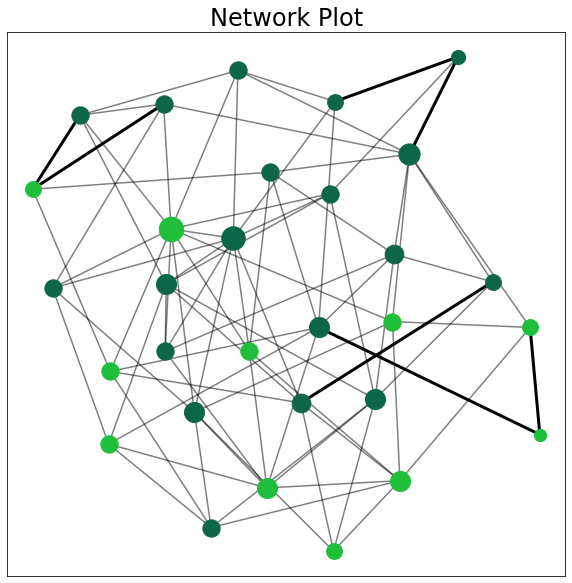

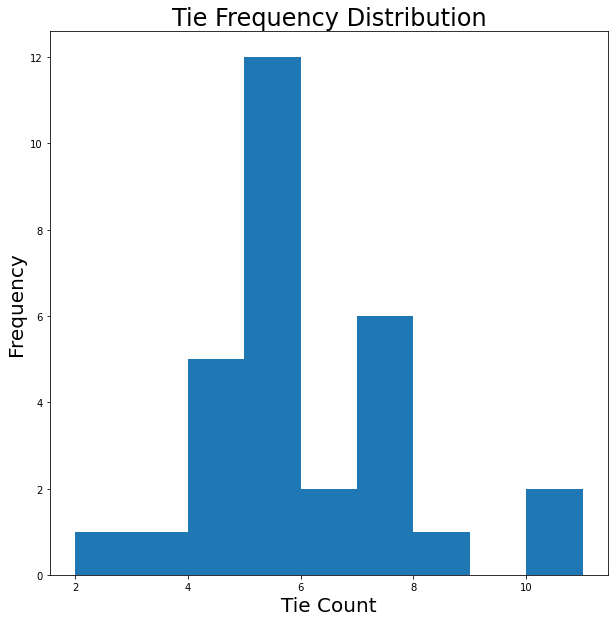

In [78]:
lamda = 2.5
n_nodes = 30

np.random.seed(0)
generator = Generator(n_nodes= n_nodes, min_tie_budget= 1,
                      max_tie_budget = 7 / n_nodes, lamda = lamda)

network = generator.GenerateNetwork(seed = 2)

simulator = Simulator(network, hire_prob = 0.4, fire_prob= 0.6)

plotter = Plotter(network, simulator, generator, tie_width= 1.5, strong_tie_width_multiplier= 2,
                  node_size = 150, node_size_scaling = 3)

plotter.PlotNetwork(saveto='netrn.png')
plotter.PlotTieDist(saveto='tiern.png')

## Scale Free Network Topology

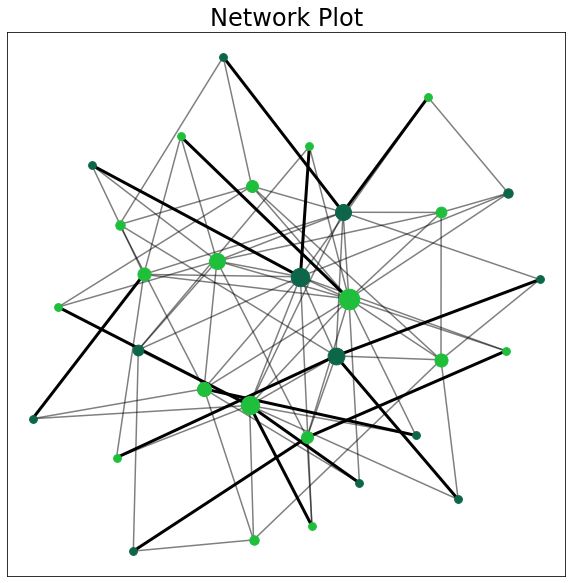

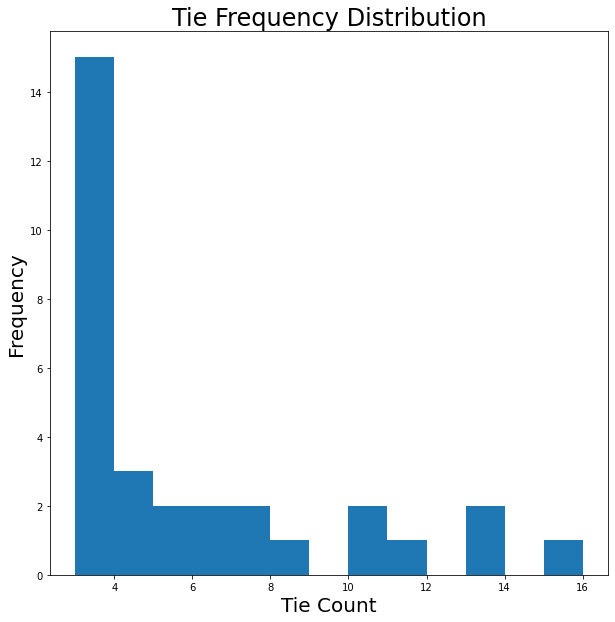

In [123]:
lamda = 2.5
n_nodes = 30

np.random.seed(0)

generator = Generator(n_nodes= n_nodes, min_tie_budget= 2, max_tie_budget = 4 / n_nodes, lamda = lamda, 
                      attach_bias = 0.001, final_budget = 2, extra_budget_tolerance= 3)

network = generator.GenerateScaleFreeNetwork(seed = 10)
network.RandomInitialization()

simulator = Simulator(network, hire_prob = 0.4, fire_prob= 0.6)


plotter = Plotter(network, simulator, generator, tie_width= 1.5, strong_tie_width_multiplier= 2,
                  node_size = 60, node_size_scaling = 6)

plotter.PlotNetwork(saveto='netsf.png')
plotter.PlotTieDist(saveto='tiesf.png')

## Small World Network Topology

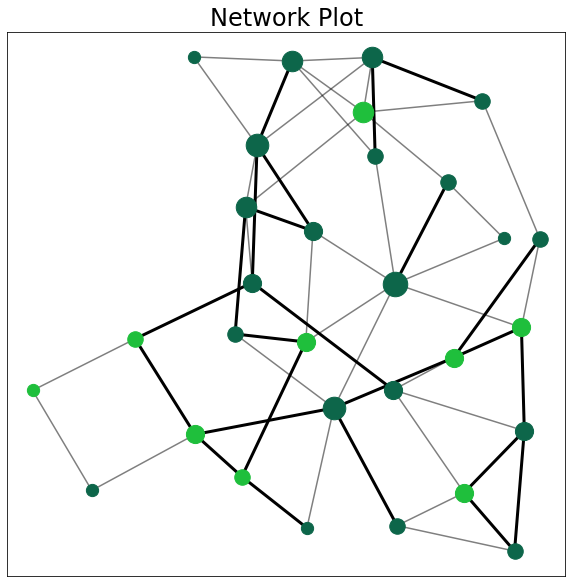

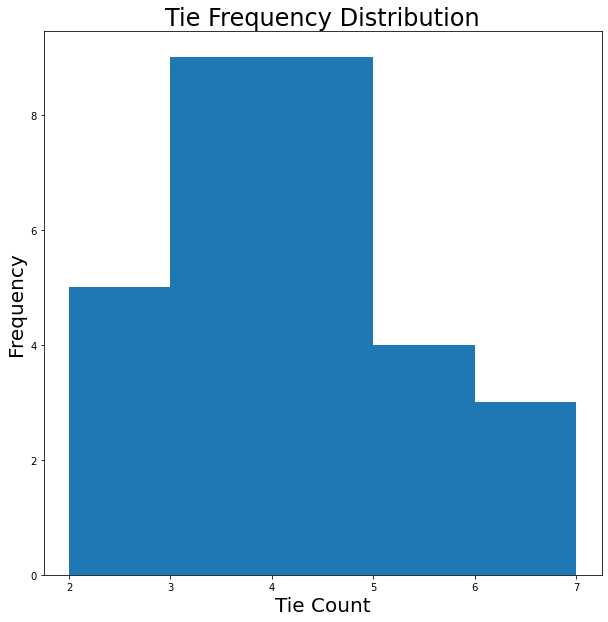

In [125]:
lamda = 2.5
n_nodes = 30

np.random.seed(0)

generator = Generator(n_nodes= n_nodes, prob_strong_tie= 0.4, min_tie_budget= 2, 
                        max_tie_budget = 7 / n_nodes, lamda = lamda, rewire_prob = 0.25)

network = generator.GenerateSmallWorldNetwork(seed = 4)

simulator = Simulator(network, hire_prob = 0.4, fire_prob= 0.6)

plotter = Plotter(network, simulator, generator, tie_width= 1.5, strong_tie_width_multiplier= 2,
                  node_size = 150, node_size_scaling = 3)

plotter.PlotNetwork(saveto='netsw.png')
plotter.PlotTieDist(saveto='tiesw.png')

# Strong Ties vs Employment Rate: Random Networks

## Lamda = 1 Plot

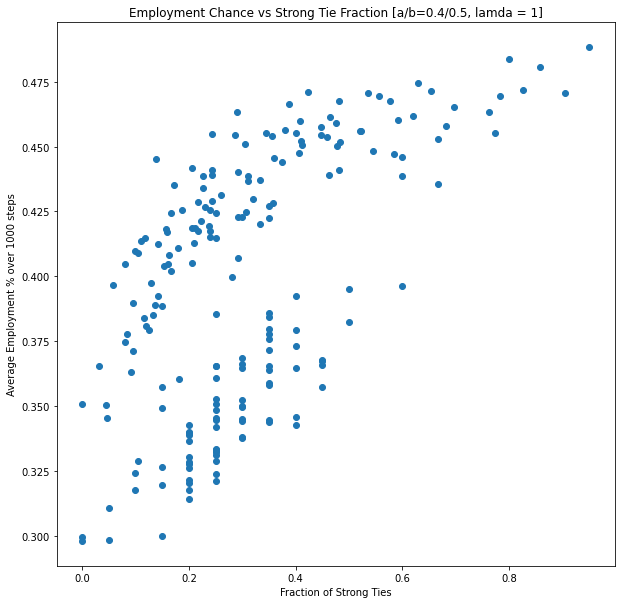

0.5926994802014417

In [132]:
generator = Generator(n_nodes= 200 , use_tie_cost_method= True, prob_strong_tie= 0.4, min_tie_budget= 20, max_tie_budget = 0.101, lamda = 1)

network = generator.GenerateNetwork()

simulator = Simulator(network, fire_prob= 0.5)
simulator.PerformSimulation()

plotter = Plotter(network, simulator, generator)

plotter.GetEmpStrongTieCorr(n_realisations = 10)

## Lamda = 2.5 Plot

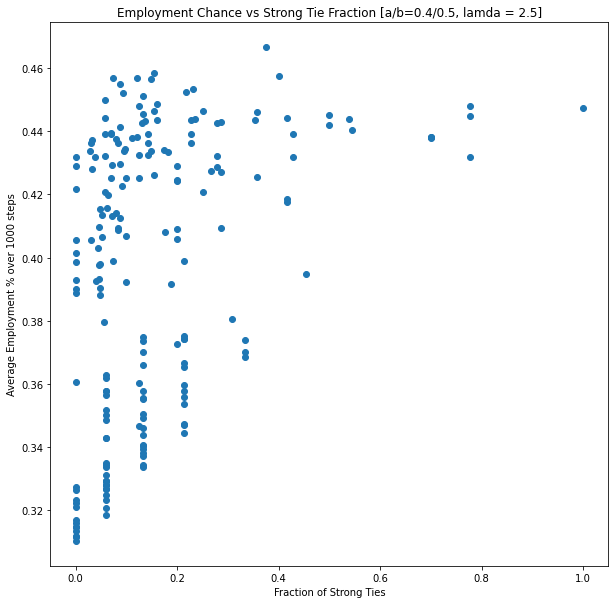

0.38770142837216615

In [133]:
generator = Generator(n_nodes= 200 , use_tie_cost_method= True, prob_strong_tie= 0.4, min_tie_budget= 20, max_tie_budget = 0.101, lamda = 2.5)

network = generator.GenerateNetwork()

simulator = Simulator(network, fire_prob= 0.5)
simulator.PerformSimulation()

plotter = Plotter(network, simulator, generator)

plotter.GetEmpStrongTieCorr(n_realisations = 10)

## Lamda = 7.5 Plot

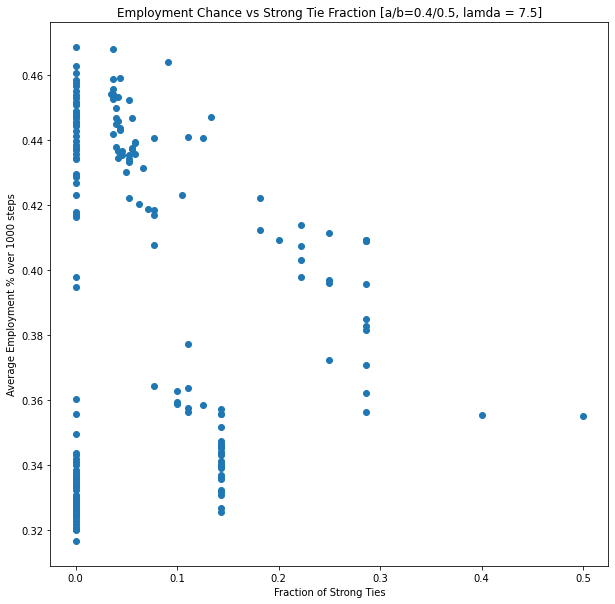

-0.05205772362649716

In [134]:
generator = Generator(n_nodes= 200 , use_tie_cost_method= True, prob_strong_tie= 0.4, min_tie_budget= 20, max_tie_budget = 0.101, lamda = 7.5)

network = generator.GenerateNetwork()

simulator = Simulator(network, fire_prob= 0.5)
simulator.PerformSimulation()

plotter = Plotter(network, simulator, generator)

plotter.GetEmpStrongTieCorr(n_realisations = 10)

## Correlation plot

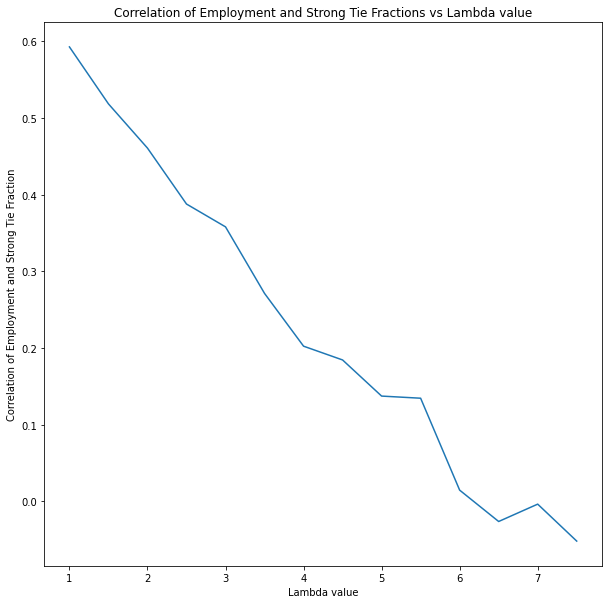

In [135]:
lamda_list = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5]
corr_list = []

for lamda in lamda_list:
  generator = Generator(n_nodes= 200 , use_tie_cost_method= True, prob_strong_tie= 0.4, min_tie_budget= 20, max_tie_budget = 0.101, lamda = lamda)

  network = generator.GenerateNetwork()

  simulator = Simulator(network, fire_prob= 0.5)
  simulator.PerformSimulation()

  plotter = Plotter(network, simulator, generator)

  corr = plotter.GetEmpStrongTieCorr(n_realisations = 10, disable_plot = True)
  corr_list.append(corr)

plt.figure(figsize = (10,10))
plt.title("Correlation of Employment and Strong Tie Fractions vs Lambda value")
plt.plot(lamda_list, corr_list)
plt.xlabel("Lambda value")
plt.ylabel("Correlation of Employment and Strong Tie Fraction")
plt.show()

# Strong Ties vs Employment Rate: All Networks

## Random Network Simulation

In [ ]:
lamda_count = 60

lamda_list = np.linspace(start = 1.25, stop = 10, num= lamda_count)
corr_list_rn = []
r_collection_rn = []
p_collection_rn = []

lmd_iter_count = 0

for lamda in lamda_list:
  lmd_iter_count += 1
  generator = Generator(n_nodes= 250 , use_tie_cost_method= True, prob_strong_tie= 0.4, 
                        min_tie_budget= 26, max_tie_budget = 34 / 250, lamda = lamda)

  network = generator.GenerateNetwork()

  simulator = Simulator(network, fire_prob= 0.6)
  # simulator.PerformSimulation()

  plotter = Plotter(network, simulator, generator)

  corr, interp_data_strip = plotter.GetEmpStrongTieCorr(n_realisations = 10, n_networks = 10,
                                                        disable_plot = True, network_type = 'Random',
                                                        return_data = True, auto_N = lamda_count)
  corr_list_rn.append(corr)
  r_collection_rn.append(interp_data_strip[0])
  p_collection_rn.append(interp_data_strip[1])

  if (lmd_iter_count % 5) == 0:
    print(f"{lmd_iter_count}th iteration completed. " + 
          f"{(len(lamda_list) - lmd_iter_count) / len(lamda_list) * 100:.2f}% Remaining")

# Save data for future access
with open('rn_data.pkl', 'wb') as f:
  pickle.dump((lamda_list, corr_list_rn, r_collection_rn, p_collection_rn), f)


5th iteration completed. 91.67% Remaining
10th iteration completed. 83.33% Remaining
15th iteration completed. 75.00% Remaining
20th iteration completed. 66.67% Remaining
25th iteration completed. 58.33% Remaining
30th iteration completed. 50.00% Remaining
35th iteration completed. 41.67% Remaining
40th iteration completed. 33.33% Remaining
45th iteration completed. 25.00% Remaining
50th iteration completed. 16.67% Remaining
55th iteration completed. 8.33% Remaining
60th iteration completed. 0.00% Remaining


### Random Network Plots

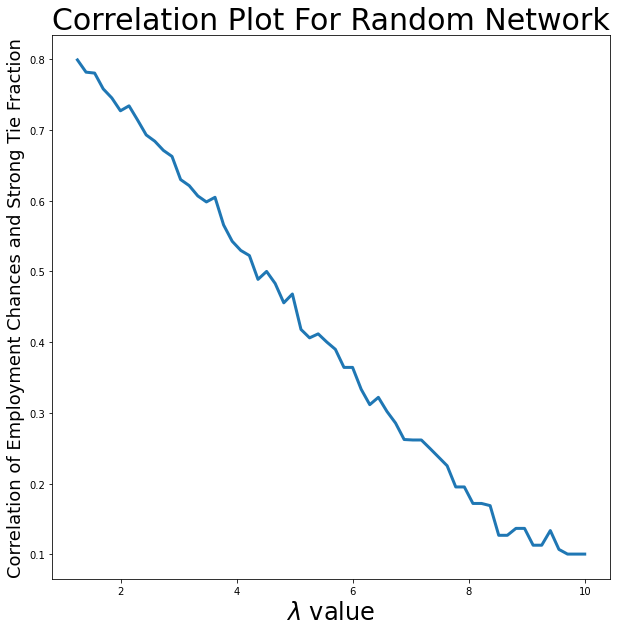

In [ ]:
# Load saved data
with open('rn_data.pkl', 'rb') as f:
  rn_data_list = pickle.load(f)

# Initialise dummy objects for function calls
try:
  plotter
except NameError:
  network = Network()
  simulator = Simulator(network)
  plotter = Plotter(network, simulator)

# Unpack saved data
lamda_list, corr_list_rn, r_collection_rn, p_collection_rn = rn_data_list

#Corr plot
plt.figure(figsize = (10,10))
plt.title("Correlation Plot For Random Network", fontsize = 30)
plt.plot(lamda_list, corr_list_rn, linewidth = 3.0)
plt.xlabel(r"$\lambda$ value", fontsize = 24)
plt.ylabel("Correlation of Employment Chances and Strong Tie Fraction", fontsize = 18)
plt.savefig("corrrn.png")
plt.show()

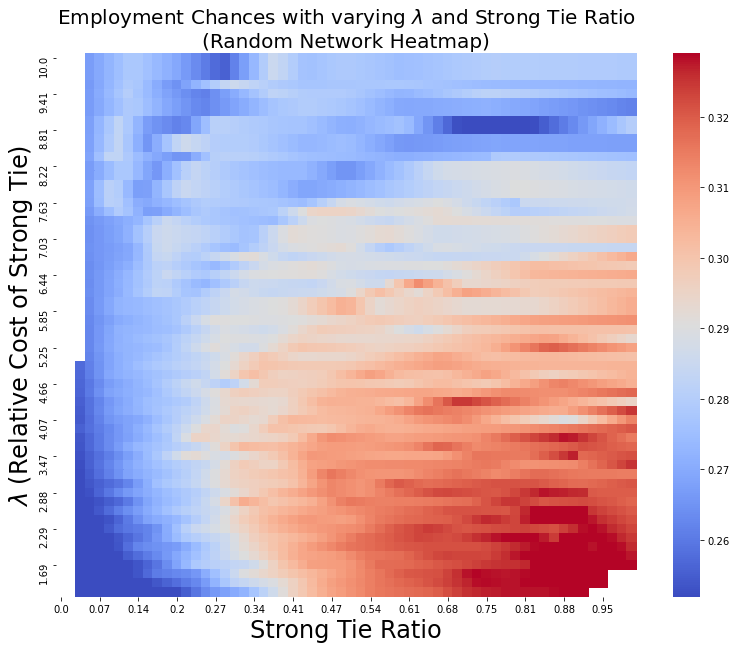

In [ ]:
lamda = np.around(np.asarray(lamda_list),2)
r = r_collection_rn
p_new = p_collection_rn

r = np.around(np.asarray(r[0]), 2)
p_mat = np.asarray(list(reversed(p_new)))

p_mat = plotter.ColumnWiseSmoothing(p_mat)

df = pd.DataFrame(p_mat, columns = r, index = reversed(lamda)) 
mask_vals = df <= 0.001

plt.figure(figsize=(13,10))
plt.title("Employment Chances with varying " + r"$\lambda$" \
 + " and Strong Tie Ratio\n(Random Network Heatmap)", fontsize = 20)
sns.heatmap(df, mask = mask_vals, robust = True, cmap = 'coolwarm', xticklabels = 4, yticklabels = 4)
plt.xlabel("Strong Tie Ratio", fontsize = 24)
plt.ylabel(r"$\lambda$" + " (Relative Cost of Strong Tie)", fontsize = 24)
plt.savefig("heatrn.png")
plt.show()

## Scale Free Network Simulation

In [ ]:
lamda_count = 60

lamda_list = np.linspace(start = 1.25, stop = 10, num= lamda_count)
corr_list_sf = []
r_collection_sf = []
p_collection_sf = []

lmd_iter_count = 0
final_budget = 28
extra_budget_tolerance = 6

for lamda in lamda_list:
  lmd_iter_count += 1
  max_tie_budget = ((final_budget + extra_budget_tolerance + 1) / (lamda + 0.5)) + (extra_budget_tolerance) / 2
  min_tie_budget = max(2, int(final_budget / 2 - lamda**2))
  generator = Generator(n_nodes= 250, prob_strong_tie= 0, min_tie_budget= min_tie_budget,
                      max_tie_budget = max_tie_budget / 250, lamda = lamda, attach_bias = 0.001,
                      final_budget = final_budget, extra_budget_tolerance= extra_budget_tolerance,
                      rewire_prob = 0)

  network = generator.GenerateScaleFreeNetwork()

  simulator = Simulator(network, hire_prob = 0.4, fire_prob= 0.6)
  simulator.PerformSimulation()

  plotter = Plotter(network, simulator, generator)

  corr, interp_data_strip = plotter.GetEmpStrongTieCorr(
      n_realisations = 10, n_networks = 10, disable_plot = True, only_consider_below_budget= 35,
      only_consider_above_budget = 28, network_type= 'ScaleFree', return_data = True,
      auto_N = lamda_count)
  
  corr_list_sf.append(corr)
  r_collection_sf.append(interp_data_strip[0])
  p_collection_sf.append(interp_data_strip[1])
  if (lmd_iter_count % 5) == 0:
    print(f"{lmd_iter_count}th iteration completed. " + 
          f"{(len(lamda_list) - lmd_iter_count) / len(lamda_list) * 100:.2f}% Remaining")


# Save data for future access
with open('sf_data.pkl', 'wb') as f:
  pickle.dump((lamda_list, corr_list_sf, r_collection_sf, p_collection_sf), f)

5th iteration completed. 91.67% Remaining
10th iteration completed. 83.33% Remaining
15th iteration completed. 75.00% Remaining
20th iteration completed. 66.67% Remaining
25th iteration completed. 58.33% Remaining
30th iteration completed. 50.00% Remaining
35th iteration completed. 41.67% Remaining
40th iteration completed. 33.33% Remaining
45th iteration completed. 25.00% Remaining
50th iteration completed. 16.67% Remaining
55th iteration completed. 8.33% Remaining
60th iteration completed. 0.00% Remaining


### Scale Free Network Plots

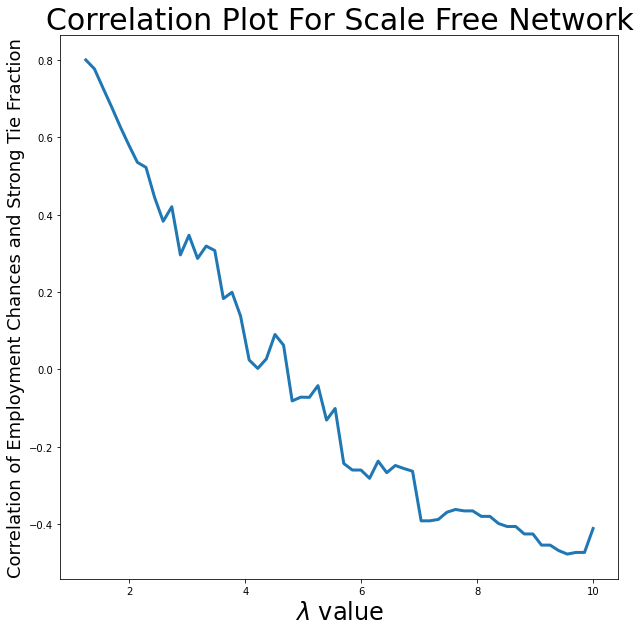

In [ ]:
# Load saved data
with open('sf_data.pkl', 'rb') as f:
  sf_data_list = pickle.load(f)

# Initialise dummy objects for function calls
try:
  plotter
except NameError:
  network = Network()
  simulator = Simulator(network)
  plotter = Plotter(network, simulator)

# Unpack saved data
lamda_list, corr_list_sf, r_collection_sf, p_collection_sf = sf_data_list

#Corr plot
plt.figure(figsize = (10,10))
plt.title("Correlation Plot For Scale Free Network", fontsize = 30)
plt.plot(lamda_list, corr_list_sf, linewidth = 3.0)
plt.xlabel(r"$\lambda$ value", fontsize = 24)
plt.ylabel("Correlation of Employment Chances and Strong Tie Fraction", fontsize = 18)
plt.savefig("corrsf.png")
plt.show()

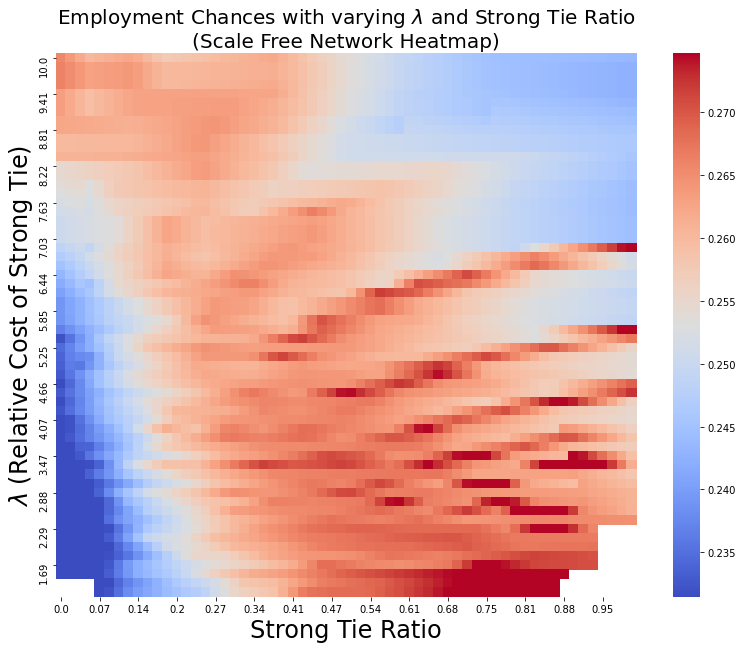

In [ ]:
lamda = np.around(np.asarray(lamda_list),2)
r = r_collection_sf
p_new = p_collection_sf

r = np.around(np.asarray(r[0]), 2)
p_mat = np.asarray(list(reversed(p_new)))

p_mat = plotter.ColumnWiseSmoothing(p_mat)

df = pd.DataFrame(p_mat, columns = r, index = reversed(lamda)) 
mask_vals = df <= 0.001

plt.figure(figsize=(13,10))
plt.title("Employment Chances with varying " + r"$\lambda$" \
 + " and Strong Tie Ratio\n(Scale Free Network Heatmap)", fontsize = 20)
sns.heatmap(df, mask = mask_vals, robust = True, cmap = 'coolwarm', xticklabels = 4, yticklabels = 4)
plt.xlabel("Strong Tie Ratio", fontsize = 24)
plt.ylabel(r"$\lambda$" + " (Relative Cost of Strong Tie)", fontsize = 24)
plt.savefig("heatsf.png")
plt.show()

## Small World Network Simulation

In [ ]:
lamda_count = 60

lamda_list = np.linspace(start = 1.25, stop = 10, num= lamda_count)
corr_list_sw = []
r_collection_sw = []
p_collection_sw = []

lmd_iter_count = 0
for lamda in lamda_list:
  lmd_iter_count += 1
  generator = Generator(n_nodes= 250, prob_strong_tie= 0.4, min_tie_budget= 30, 
                        max_tie_budget = 30.1 / 250, lamda = lamda, attach_bias = 0.001, 
                        final_budget = 30, extra_budget_tolerance = 6, rewire_prob = 0.25)

  network = generator.GenerateSmallWorldNetwork()

  simulator = Simulator(network, fire_prob= 0.6)
  simulator.PerformSimulation()

  plotter = Plotter(network, simulator, generator)

  corr, interp_data_strip = plotter.GetEmpStrongTieCorr(
      n_realisations = 10, n_networks = 10, disable_plot = True, network_type = 'SmallWorld',
      return_data = True, auto_N = lamda_count)
  
  corr_list_sw.append(corr)
  r_collection_sw.append(interp_data_strip[0])
  p_collection_sw.append(interp_data_strip[1])
  if (lmd_iter_count % 5) == 0:
    print(f"{lmd_iter_count}th iteration completed. " + 
          f"{(len(lamda_list) - lmd_iter_count) / len(lamda_list) * 100:.2f}% Remaining")

# Save data for future access
with open('sw_data.pkl', 'wb') as f:
  pickle.dump((lamda_list, corr_list_sw, r_collection_sw, p_collection_sw), f)


5th iteration completed. 91.67% Remaining
10th iteration completed. 83.33% Remaining
15th iteration completed. 75.00% Remaining
20th iteration completed. 66.67% Remaining
25th iteration completed. 58.33% Remaining
30th iteration completed. 50.00% Remaining
35th iteration completed. 41.67% Remaining
40th iteration completed. 33.33% Remaining
45th iteration completed. 25.00% Remaining
50th iteration completed. 16.67% Remaining
55th iteration completed. 8.33% Remaining
60th iteration completed. 0.00% Remaining


### Small World Network Plots

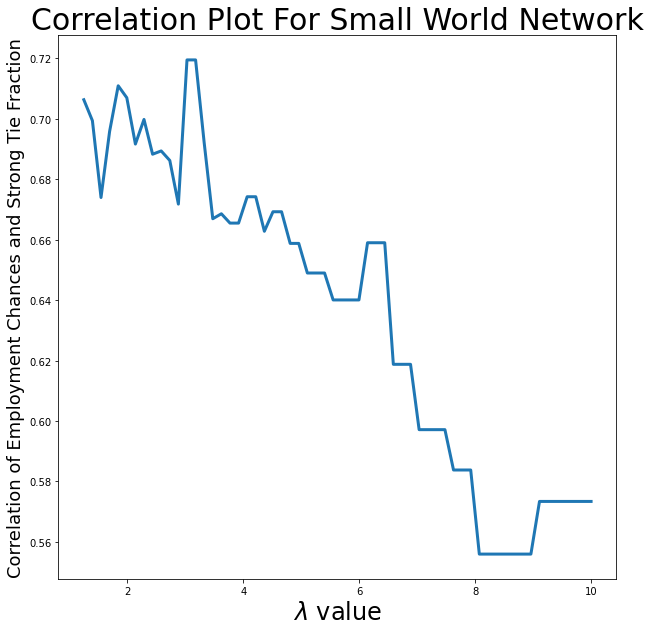

In [ ]:
# Load saved data
with open('sw_data.pkl', 'rb') as f:
  sw_data_list = pickle.load(f)

# Initialise dummy objects for function calls
try:
  plotter
except NameError:
  network = Network()
  simulator = Simulator(network)
  plotter = Plotter(network, simulator)

# Unpack saved data
lamda_list, corr_list_sw, r_collection_sw, p_collection_sw = sw_data_list

#Corr plot
plt.figure(figsize = (10,10))
plt.title("Correlation Plot For Small World Network", fontsize = 30)
plt.plot(lamda_list, corr_list_sw, linewidth = 3.0)
plt.xlabel(r"$\lambda$ value", fontsize = 24)
plt.ylabel("Correlation of Employment Chances and Strong Tie Fraction", fontsize = 18)
plt.savefig("corrsw.png")
plt.show()

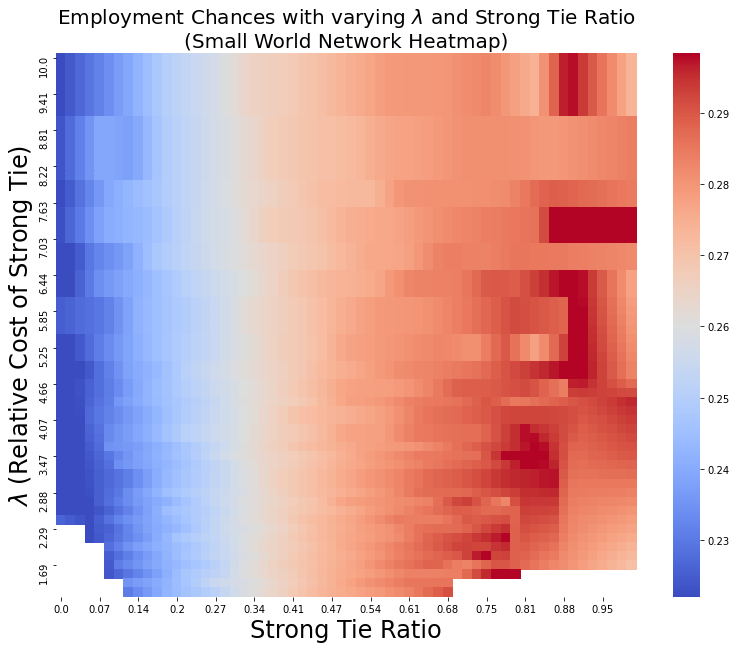

In [ ]:
lamda = np.around(np.asarray(lamda_list),2)
r = r_collection_sw
p_new = p_collection_sw

r = np.around(np.asarray(r[0]), 2)
p_mat = np.asarray(list(reversed(p_new)))

p_mat = plotter.ColumnWiseSmoothing(p_mat)

df = pd.DataFrame(p_mat, columns = r, index = reversed(lamda)) 
mask_vals = df <= 0.001

plt.figure(figsize=(13,10))
plt.title("Employment Chances with varying " + r"$\lambda$" \
 + " and Strong Tie Ratio\n(Small World Network Heatmap)", fontsize = 20)
sns.heatmap(df, mask = mask_vals, robust = True, cmap = 'coolwarm', xticklabels = 4, yticklabels = 4)
plt.xlabel("Strong Tie Ratio", fontsize = 24)
plt.ylabel(r"$\lambda$" + " (Relative Cost of Strong Tie)", fontsize = 24)
plt.savefig("heatsw.png")
plt.show()

# All Correlations in One Plot

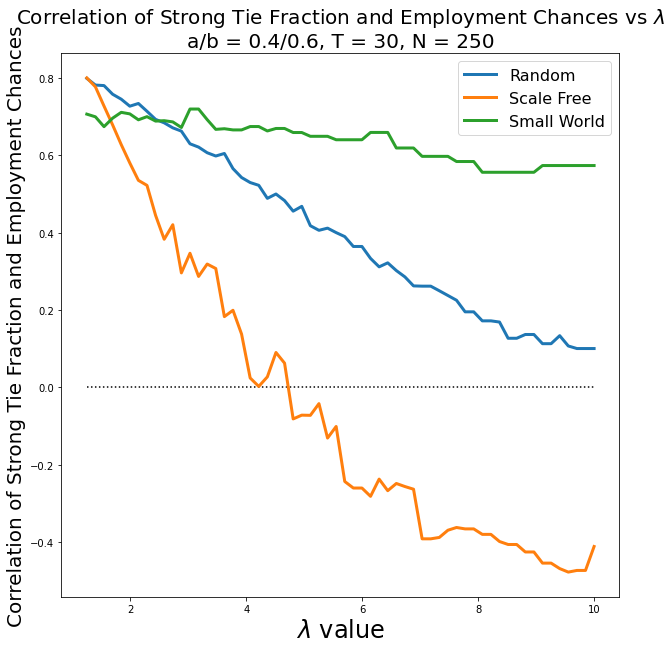

In [ ]:
plt.figure(figsize= (10,10))
plt.title(r"Correlation of Strong Tie Fraction and Employment Chances vs $\lambda$" + f"\na/b = {simulator.alpha}/{simulator.beta}, T = 30, N = 250", fontsize = 20)
plt.plot(lamda_list, corr_list_rn, label="Random", linewidth = 3.0)
plt.plot(lamda_list, corr_list_sf, label="Scale Free", linewidth = 3.0)
plt.plot(lamda_list, corr_list_sw, label="Small World", linewidth = 3.0)
plt.hlines(0, xmin = min(lamda_list), xmax = max(lamda_list), linestyles='dotted')
plt.xlabel(r"$\lambda$ value", fontsize = 24)
plt.ylabel("Correlation of Strong Tie Fraction and Employment Chances", fontsize = 20)
plt.legend(fontsize=16)
plt.savefig("corrall.png")
plt.show()

# Theoretical Solution

In [ ]:
def func(x, a, b, w, s):
    """
    Functional form of the expression for p_ss.
    Solving this function wrt x will obtain a value for p_ss
    """
    return (a*(1 - b) + (1 - a)*(1 - (((1 - x) + x*(1 - a) + x*a*(1 - 1/((1 - x)*s)))**s)*(((1 - x) + x*(1 - a) + x*a*(1 - x**s) + x*a*(x**s)*(1 - 1/((1 - x)*w))))**w)*(1 - b))*(1 - x) + (1 - b)*x - x;

In [ ]:
# Define Parameters

a = 0.4
b = 0.6
T = 30

# Choose interval length
num = 50

# Define lamda range
lamda_list = np.linspace(start = 1.25, stop = 10, num= num)
num = len(lamda_list)

corr_list = np.zeros(num)
p_matrix = np.zeros((num, T+1))
p_collection = []
r_collection = []

# Iterate over each lambda
for i, lamda in enumerate(lamda_list):

    # Set s to account for approximately 66% of T
    s = int((2/3)*(T / lamda))
    # Set w to account for rest of budget.
    w = int(T - s)

    # Analytically solve for p_ss for the provided s and w
    x0 = 0.5
    pss = fsolve(func, x0, args=(a, b, w, s))

    # Find probability of strong & weak tie recommendations
    p_nR_Si = (1 - pss) + pss*(1 - a) + pss*a*(1 - 1/((1 - pss)*s))
    p_nR_Wj = (1 - pss) + pss*(1 - a) + pss*a*(1 - pss**s) + pss*a*(pss**s)*(1 - 1/((1 - pss)*w))

    p_new_list = []
    r_list = []

    # Now, allow ego to set their number of strong & weak ties.
    # Iterate over each possible value of x
    for x in range(0, int(T / lamda) + 1):
        # y will account for rest of budget
        y = int(T - lamda * x)

        r = x / (x + y)

        # Calculate Ego's total probability of being recommended a job
        Pr_ego = 1 - ((p_nR_Si)**x)*((p_nR_Wj)**y)
        # Closed form expression for p_new
        p_new = (a + (1 - a)*Pr_ego)*(1 - b)/(1 - (1 - b)*(1 - a)*(1 - Pr_ego))
        
        # Collect the results
        p_new_list.append(p_new[0])
        r_list.append(r)

    r_collection.append(r_list)
    p_collection.append(p_new_list)
    corr_list[i] = np.corrcoef(r_list, p_new_list)[0, 1]

## Theoretical Solution Plots

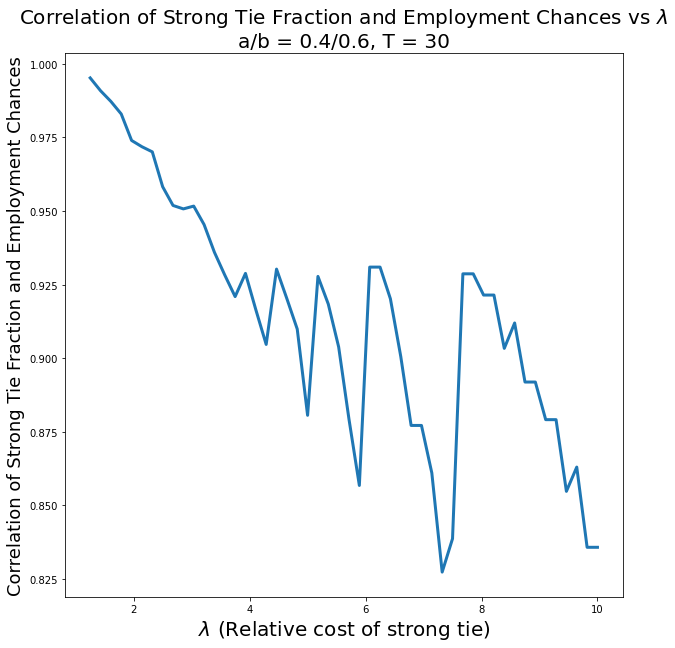

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(lamda_list, corr_list, linewidth = 3.0)
plt.xlabel(r'$\lambda$ (Relative cost of strong tie)', fontsize = 20)
plt.ylabel("Correlation of Strong Tie Fraction and Employment Chances", fontsize = 18)
plt.title(f"Correlation of Strong Tie Fraction and Employment Chances vs "+ r"$\lambda$" +\
          f"\na/b = {a}/{b}, T = {T}", fontsize = 20)
plt.savefig("corrtheory.png")
plt.show()

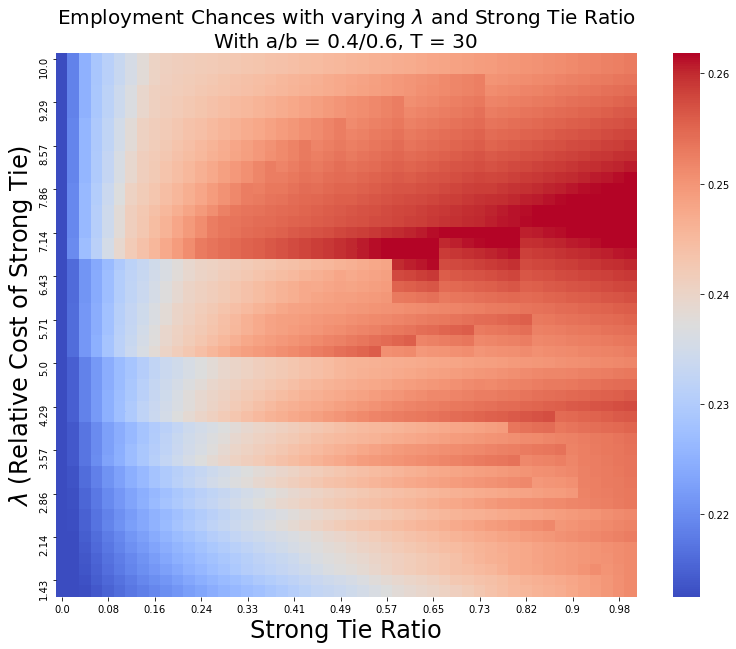

In [ ]:
def InterpolateColumns(p_collection, r_collection, col_num):
  """
  Function to interpolate between columns of the heatmap to fill in missing values.
  As r values are discontinuous and non-uniform across values of lambda, they will be
  smoothed out using linear interpolation.
  """
  col_array = np.linspace(0,1,num=col_num)
  tol = 1e-4
  A = p_collection
  
  row = len(p_collection)
  A_new = np.zeros((row, col_num))

  # Iterate through each column
  for idx in range(row):
    r = r_collection[idx]
    row_vals = A[idx]
    # find the indices where values actually exist

    min_r_val = np.min(r)
    max_r_val = np.max(r)
    
    r_new = np.zeros(col_num)

    # Iterate through each element in this column
    for jdx in range(col_num):
      r_idx = jdx / (col_num - 1)
      r_new[jdx] = r_idx
      if r_idx < min_r_val or r_idx > max_r_val:
        continue
      # Find the neighbouring indices
      for kdx in range(len(r)):
        if r[kdx] > (r_idx + tol):
          more_r_idx = r[kdx]
          less_r_idx = r[kdx - 1]
          more_val = row_vals[kdx]
          less_val = row_vals[kdx - 1]
          break
      # Found neighbouring indices. Now interp between them
      cur_val = less_val + (r_idx - less_r_idx) / (more_r_idx - less_r_idx) * (more_val - less_val)
      A_new[idx, jdx] = cur_val

  return A_new, r_new

# Requires use of the Plotter class. If it doesn't exist, create a dummy version for using functions
try:
  plotter
except NameError:
  network = Network()
  simulator = Simulator(network)
  plotter = Plotter(network, simulator)

lamda = np.around(np.asarray(lamda_list),2)

# Smooth the heat values by creating uniformly distributed heat values in between the 
# original values
p_mat_new, r_new = InterpolateColumns(p_collection, r_collection, 50)
# The missing values in the columns are now imputed in a smooth manner
p_mat_new = plotter.ColumnWiseSmoothing(p_mat_new)
p_mat_new = np.flip(p_mat_new, axis = 0)

r_new = np.around(r_new,2)

# Heatmap is created, and indexed as a dataframe
df = pd.DataFrame(p_mat_new, columns = r_new, index = reversed(lamda)) 
mask_vals = df <= 0.001

plt.figure(figsize=(13,10))
plt.title("Employment Chances with varying " + r"$\lambda$" \
 + f" and Strong Tie Ratio\nWith a/b = {a}/{b}, T = {T}", fontsize = 20)
sns.heatmap(df, mask = mask_vals, robust = True, cmap = 'coolwarm', xticklabels = 4, yticklabels = 4)
plt.xlabel("Strong Tie Ratio", fontsize = 24)
plt.ylabel(r"$\lambda$" + " (Relative Cost of Strong Tie)", fontsize = 24)
plt.savefig("heattheory.png")
plt.show()